# <span style="color:blue">FAA Wildlife Strike Analysis</span>
### Analytical Report & Predictive Modeling
This notebook provides a comprehensive exploratory and predictive analysis of the FAA Wildlife Strike Database. The main goal is to identify patterns, trends, and insights regarding wildlife strikes, aiding in developing strategies for wildlife hazard mitigation at airports.

I also built a predictive model to forecast the likelihood of a wildlife strike to be severe at an airport based on various factors such as the time of day, month, region, species involved, strike position and aircraft characters. The model can be used to predict the probability of a wildlife strike at an airport and help in planning preventive measures.


In [ ]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# build random forest model to predict the SEVERITY
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

# set display options
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
data_path = 'data/'

## Data Loading and Initial Examination
The dataset was loaded and initially inspected to understand the structure, completeness, and potential data quality issues. The preliminary examination focused on understanding column types, missing values, and identifying key features for further analysis.


In [2]:
# load data, 
df = pd.read_excel(data_path + 'Public.xlsx')

In [3]:
# what it looks like
df.tail()

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,RUNWAY,STATE,FAAREGION,LOCATION,OPID,OPERATOR,REG,FLT,AIRCRAFT,AMA,AMO,EMA,EMO,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,ENG_1_POS,ENG_2_POS,ENG_3_POS,ENG_4_POS,PHASE_OF_FLIGHT,HEIGHT,SPEED,DISTANCE,SKY,PRECIPITATION,AOS,COST_REPAIRS,COST_OTHER,COST_REPAIRS_INFL_ADJ,COST_OTHER_INFL_ADJ,INGESTED_OTHER,INDICATED_DAMAGE,DAMAGE_LEVEL,STR_RAD,DAM_RAD,STR_WINDSHLD,DAM_WINDSHLD,STR_NOSE,DAM_NOSE,STR_ENG1,DAM_ENG1,ING_ENG1,STR_ENG2,DAM_ENG2,ING_ENG2,STR_ENG3,DAM_ENG3,ING_ENG3,STR_ENG4,DAM_ENG4,ING_ENG4,STR_PROP,DAM_PROP,STR_WING_ROT,DAM_WING_ROT,STR_FUSE,DAM_FUSE,STR_LG,DAM_LG,STR_TAIL,DAM_TAIL,STR_LGHTS,DAM_LGHTS,STR_OTHER,DAM_OTHER,OTHER_SPECIFY,EFFECT,EFFECT_OTHER,BIRD_BAND_NUMBER,SPECIES_ID,SPECIES,OUT_OF_RANGE_SPECIES,REMARKS,REMAINS_COLLECTED,REMAINS_SENT,WARNED,NUM_SEEN,NUM_STRUCK,SIZE,ENROUTE_STATE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
316478,1620505,2024-11-14,11,2024,,NaN,KDFW,DALLAS/FORT WORTH INTL ARPT,32.89595,-97.0372,18R/36L,TX,ASW,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,R2004,Short-eared owl,0,Found whole remains during 36L DRI north of TW...,1,0,Yes,NaN,1,Small,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Carcass Found,2025-03-27,0
316479,1620506,2024-11-13,11,2024,,NaN,KMHR,SACRAMENTO MATHER ARPT,38.5539,-121.29759,22R,CA,AWP,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,YH004,Horned lark,0,Upon routine inspection of RWY 22R a small str...,1,1,Yes,NaN,1,Small,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Carcass Found,2025-03-27,0
316480,1620507,2024-11-14,11,2024,13:25,Day,KORD,CHICAGO O'HARE INTL ARPT,41.9796,-87.90446,27R,IL,AGL,NaN,ENY,ENVOY AIR,N751AB,3528,EMB-170,332,NaN,22.0,4.0,A,4.0,D,2.0,1.0,1.0,NaN,NaN,Approach,1000.0,140.0,3.0,Overcast,Rain,NaN,NaN,NaN,NaN,NaN,0,0,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,None,NaN,NaN,UNKBS,Unknown bird - small,0,NaN,0,0,Unknown,NaN,1,Small,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Pilot,2025-03-27,0
316481,1620508,2024-11-12,11,2024,,NaN,ZZZZ,UNKNOWN,NaN,NaN,NaN,NaN,NaN,FOUND KDFW,ENY,ENVOY AIR,N224NN,NaN,EMB-170,332,NaN,22.0,4.0,A,4.0,D,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,N5111,Killdeer,0,Unconfirmed location of strike. Envoy maintena...,1,1,Unknown,NaN,1,Small,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,2025-03-27,0
316482,1620509,2024-11-13,11,2024,,NaN,KDAB,DAYTONA BEACH INTL,29.17992,-81.05806,7L,FL,ASO,NaN,UNK,UNKNOWN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,K5114,American kestrel,0,Unknown-An additional Kestrel Carcass was foun...,1,1,Unknown,NaN,1,Small,NaN,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Carcass Found,2025-03-27,0


In [4]:
# load the description of the columns
col_name = pd.read_csv(data_path + 'read_me.csv')
# make it a dictionary for easy access
col_name_dict = col_name.set_index('Column Name')['Explanation of Column Name and Codes'].to_dict()
col_name_dict

{'INDEX NR': 'Individual record number',
 'OPID': 'Airline operator code',
 'OPERATOR': 'A three letter International Civil Aviation Organization code for aircraft operators. (BUS = business, PVT = private aircraft other than business, GOV = government aircraft, MIL - military aircraft.)',
 'ATYPE': 'Aircraft',
 'AMA': 'International Civil Aviation Organization code for Aircraft Make',
 'AMO': 'International Civil Aviation Organization code for Aircraft Model ',
 'EMA': 'Engine Make Code (see Engine Codes tab below)',
 'EMO': 'Engine Model Code (see Engine Codes tab below)',
 'AC_CLASS': 'Type of aircraft (see Aircraft Type tab below)',
 'AC_MASS': '1 = 2,250 kg or less: 2 = ,2251-5700 kg: 3 = 5,701-27,000 kg: 4 = 27,001-272,000 kg: 5 = above 272,000 kg',
 'NUM_ENGS': 'Number of engines',
 'TYPE_ENG': 'Type of power A = reciprocating engine (piston): B = Turbojet: C = Turboprop: D = Turbofan: E = None (glider): F = Turboshaft (helicopter): Y = Other',
 'ENG_1_POS': 'Where engine # 1 is

## Data Cleaning and Preparation
After initial inspection, significant data cleaning steps were taken:
- Handling missing values.
- Dropping irrelevant or redundant columns.
- Ensuring consistent formatting for analysis.
- Feature engineering to extract useful information from existing columns.

Clean and properly formatted data is crucial for accurate analysis and modeling.


In [5]:
print("shape of the data: ", df.shape)

shape of the data:  (316483, 101)


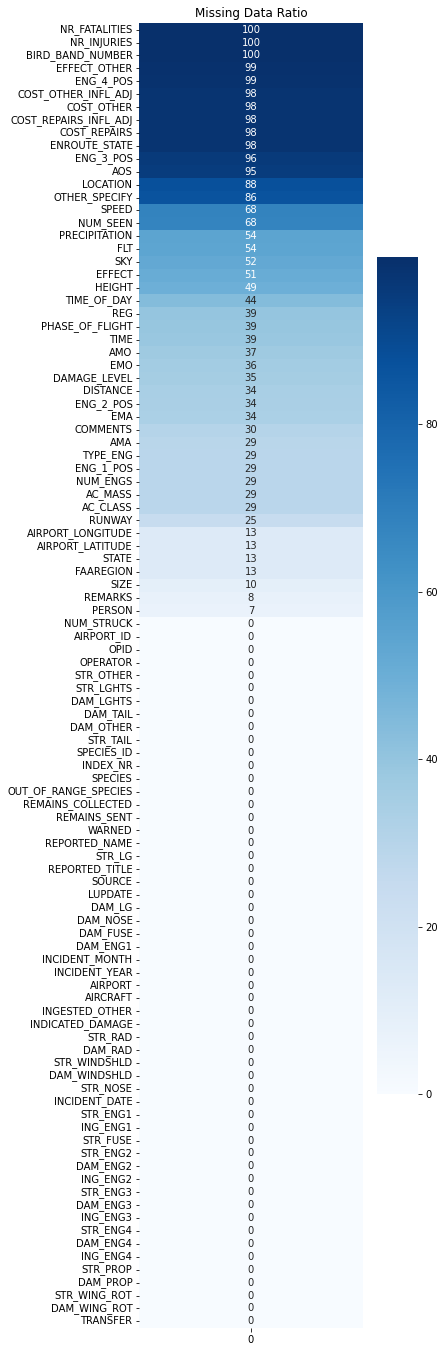

In [6]:
# plot the missing ratio of each column 
plt.figure(figsize=(5,24))
missing_data = (df.isnull().mean()*100).sort_values(ascending=False)
sns.heatmap(missing_data.to_frame(), cmap='Blues', annot=True, fmt='.0f')
plt.title('Missing Data Ratio')
plt.show()


## missing values and data cleaning

In [7]:
# show cols with more than 50% missing values
high_missing_cols = missing_data[missing_data > 50].index
# show the col names and the explanation from the dictionary
for col in high_missing_cols:
    if col in col_name_dict:
        print(col, ":", col_name_dict[col])
    else:
        print(col, ":","Explanation not found in dictionary")

NR_FATALITIES : Number of human fatalities
NR_INJURIES : Number of people injured
BIRD_BAND_NUMBER : Bird Band Number associated with the wildlife struck
EFFECT_OTHER : Effect on flight other than those listed on the form
ENG_4_POS : Where engine # 4 is mounted  on aircraft (see Engine Position tab below)
COST_OTHER_INFL_ADJ : Costs adjusted to the most recent year based on Consumer Price Index, U.S. Department of Labor.  Inflation-adjusted costs are updated annually.
COST_OTHER : Estimated other costs, other than those in previous field in dollars (USD). May include loss of revenue, hotel expenses due to flight cancellation, costs of fuel dumped, etc.
COST_REPAIRS_INFL_ADJ : Costs adjusted to the most recent year based on Consumer Price Index, U.S. Department of Labor.  Inflation-adjusted costs are updated annually.
COST_REPAIRS : Estimated cost of repairs of replacement in dollars (USD)
ENROUTE_STATE : Explanation not found in dictionary
ENG_3_POS : Where engine # 3 is mounted  on ai

From the above output, we can see that the columns with more than 50% missing values are not useful for our analysis
So I just drop off the columns with more than 50% missing values

In [8]:
# drop columns with more than 50% missing values
df_less_missing = df.drop(columns=high_missing_cols).copy()
# drop uninformative columns, LUPDATE, TRANSFER, REPORTED_NAME, REPORTED_TITLE as they have only one unique value
df_less_missing.drop(columns=['REPORTED_NAME', 'REPORTED_TITLE', 'LUPDATE', 'TRANSFER'], inplace=True)

In [9]:
df_less_missing.tail()

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,RUNWAY,STATE,FAAREGION,OPID,OPERATOR,REG,AIRCRAFT,AMA,AMO,EMA,EMO,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,ENG_1_POS,ENG_2_POS,PHASE_OF_FLIGHT,HEIGHT,DISTANCE,INGESTED_OTHER,INDICATED_DAMAGE,DAMAGE_LEVEL,STR_RAD,DAM_RAD,STR_WINDSHLD,DAM_WINDSHLD,STR_NOSE,DAM_NOSE,STR_ENG1,DAM_ENG1,ING_ENG1,STR_ENG2,DAM_ENG2,ING_ENG2,STR_ENG3,DAM_ENG3,ING_ENG3,STR_ENG4,DAM_ENG4,ING_ENG4,STR_PROP,DAM_PROP,STR_WING_ROT,DAM_WING_ROT,STR_FUSE,DAM_FUSE,STR_LG,DAM_LG,STR_TAIL,DAM_TAIL,STR_LGHTS,DAM_LGHTS,STR_OTHER,DAM_OTHER,SPECIES_ID,SPECIES,OUT_OF_RANGE_SPECIES,REMARKS,REMAINS_COLLECTED,REMAINS_SENT,WARNED,NUM_STRUCK,SIZE,COMMENTS,SOURCE,PERSON
316478,1620505,2024-11-14,11,2024,,NaN,KDFW,DALLAS/FORT WORTH INTL ARPT,32.89595,-97.0372,18R/36L,TX,ASW,UNK,UNKNOWN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,R2004,Short-eared owl,0,Found whole remains during 36L DRI north of TW...,1,0,Yes,1,Small,NaN,FAA Form 5200-7-E,Carcass Found
316479,1620506,2024-11-13,11,2024,,NaN,KMHR,SACRAMENTO MATHER ARPT,38.5539,-121.29759,22R,CA,AWP,UNK,UNKNOWN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YH004,Horned lark,0,Upon routine inspection of RWY 22R a small str...,1,1,Yes,1,Small,NaN,FAA Form 5200-7-E,Carcass Found
316480,1620507,2024-11-14,11,2024,13:25,Day,KORD,CHICAGO O'HARE INTL ARPT,41.9796,-87.90446,27R,IL,AGL,ENY,ENVOY AIR,N751AB,EMB-170,332,NaN,22.0,4.0,A,4.0,D,2.0,1.0,1.0,Approach,1000.0,3.0,0,0,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,UNKBS,Unknown bird - small,0,NaN,0,0,Unknown,1,Small,NaN,FAA Form 5200-7-E,Pilot
316481,1620508,2024-11-12,11,2024,,NaN,ZZZZ,UNKNOWN,NaN,NaN,NaN,NaN,NaN,ENY,ENVOY AIR,N224NN,EMB-170,332,NaN,22.0,4.0,A,4.0,D,2.0,1.0,1.0,NaN,NaN,NaN,0,0,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,N5111,Killdeer,0,Unconfirmed location of strike. Envoy maintena...,1,1,Unknown,1,Small,NaN,FAA Form 5200-7-E,Airport Operations
316482,1620509,2024-11-13,11,2024,,NaN,KDAB,DAYTONA BEACH INTL,29.17992,-81.05806,7L,FL,ASO,UNK,UNKNOWN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,K5114,American kestrel,0,Unknown-An additional Kestrel Carcass was foun...,1,1,Unknown,1,Small,NaN,FAA Form 5200-7-E,Carcass Found


## Exploratory Data Analysis (EDA)
A thorough exploratory analysis was performed to identify:
- Trends and frequency of wildlife strikes over diverse factors.
- Features that significantly impact the severity of wildlife strikes.
- Feature engineering to extract useful information from existing columns.

Based on analysis actionable insights were derived to develop strategies for wildlife hazard mitigation at airports.:



In [10]:
# show the description of the columns
df_less_missing.describe()

,INDEX_NR,INCIDENT_MONTH,INCIDENT_YEAR,EMA,EMO,AC_MASS,NUM_ENGS,ENG_1_POS,ENG_2_POS,HEIGHT,DISTANCE,INGESTED_OTHER,INDICATED_DAMAGE,STR_RAD,DAM_RAD,STR_WINDSHLD,DAM_WINDSHLD,STR_NOSE,DAM_NOSE,STR_ENG1,DAM_ENG1,ING_ENG1,STR_ENG2,DAM_ENG2,ING_ENG2,STR_ENG3,DAM_ENG3,ING_ENG3,STR_ENG4,DAM_ENG4,ING_ENG4,STR_PROP,DAM_PROP,STR_WING_ROT,DAM_WING_ROT,STR_FUSE,DAM_FUSE,STR_LG,DAM_LG,STR_TAIL,DAM_TAIL,STR_LGHTS,DAM_LGHTS,STR_OTHER,DAM_OTHER,OUT_OF_RANGE_SPECIES,REMAINS_COLLECTED,REMAINS_SENT
count,3.164830e+05,316483.000000,316483.000000,210393.000000,201894.000000,226120.000000,225857.000000,225833.000000,210070.000000,159897.000000,207803.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000,316483.000000
mean,9.671110e+05,7.221118,2012.748362,19.527213,8.311272,3.549164,2.009099,2.765322,2.595935,875.209460,0.853637,0.035793,0.065605,0.089847,0.006642,0.119769,0.004616,0.115358,0.005530,0.046053,0.009694,0.004206,0.039358,0.008184,0.004316,0.001564,0.000528,0.000057,0.000755,0.000215,0.000009,0.016032,0.002221,0.120013,0.019748,0.087863,0.003798,0.041847,0.004120,0.010061,0.003286,0.004819,0.003232,0.134544,0.007681,0.000509,0.532196,0.172616
std,3.371839e+05,2.752761,8.742391,10.634096,11.602185,0.866194,0.414831,2.117554,1.969322,1850.048523,3.642867,0.185775,0.247591,0.285963,0.081226,0.324692,0.067787,0.319455,0.074155,0.209600,0.097980,0.064714,0.194445,0.090093,0.065556,0.039517,0.022965,0.007541,0.027470,0.014657,0.003079,0.125600,0.047078,0.324977,0.139134,0.283095,0.061511,0.200241,0.064057,0.099797,0.057230,0.069249,0.056762,0.341237,0.087306,0.022549,0.498963,0.377915
min,6.082420e+05,1.000000,1990.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.977895e+05,5.000000,2007.000000,10.000000,1.000000,3.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.844910e+05,8.000000,2015.000000,22.000000,4.000000,4.000000,2.000000,1.000000,1.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.304768e+06,9.000000,2020.000000,31.000000,10.000000,4.000000,2.000000,5.000000,5.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.620509e+06,12.000000,2025.000000,47.000000,97.000000,5.000000,4.000000,7.000000,7.000000,32000.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0

In [11]:
# show the numbers of unique values of the categorical columns
df_less_missing.select_dtypes(include='object').nunique()

INCIDENT_DATE         12707
TIME                   1441
TIME_OF_DAY               4
AIRPORT_ID             2697
AIRPORT                2704
AIRPORT_LATITUDE       2687
AIRPORT_LONGITUDE      2688
RUNWAY                 1327
STATE                    67
FAAREGION                10
OPID                    622
OPERATOR                618
REG                   44616
AIRCRAFT                612
AMA                      94
AMO                      63
AC_CLASS                  5
TYPE_ENG                  7
PHASE_OF_FLIGHT          12
DAMAGE_LEVEL              5
SPECIES_ID              931
SPECIES                 931
REMARKS              265265
WARNED                    3
NUM_STRUCK                4
SIZE                      3
COMMENTS             207231
SOURCE                   16
PERSON                    6
dtype: int64

 ### Damage level

 There are 2 columns that are related to damage level, DAMAGE_LEVEL, and INDICATED_DAMAGE. I will check the relationship between these two columns and drop one of them if they are highly correlated.

In [12]:
# for the damage level, if NA, fill with "missing"
df_less_missing['DAMAGE_LEVEL'].fillna('missing', inplace=True)
# let check the DAMAGE_LEVEL and INDICATED_DAMAGE, show the cross tabulation
pd.crosstab(df_less_missing['DAMAGE_LEVEL'], df_less_missing['INDICATED_DAMAGE'])


INDICATED_DAMAGE,0,1
DAMAGE_LEVEL,,
D,0,88
M,0,8672
M?,0,7665
N,183751,1
S,0,4335
missing,111969,2


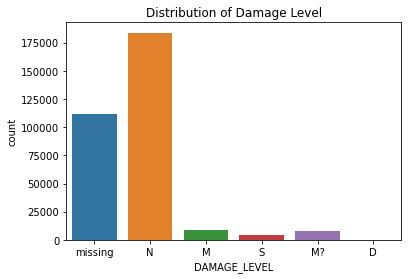

In [13]:
# plot the distribution of the damage level
sns.countplot(x='DAMAGE_LEVEL', data=df_less_missing)
plt.title('Distribution of Damage Level')
plt.show()


There are almost 40% of the data missing in the column DAMAGE_LEVEL, but from the information from `Remarks` and `Effect` columns, we can see that the column the missing values are most likely minor damage or even no damage. So I will fill the missing values with "Minor" damage.

The aim of the study is to avoid sever damages, as the strike looks unavoidable.  

I regroup the damage level into 2 categories, with a new col name "SEVERITY". The new column will have 2 categories, "SEVERE" and "NOT SEVERE". The "SEVERE" category will include the "Substantial" and "Destroyed" in the original damage levels, while others will be in the "NOT SEVERE" category.

In [14]:
# re-group the damage level as 'Severe' and 'Not Severe'
df_less_missing['SEVERITY'] = df_less_missing['DAMAGE_LEVEL'].apply(lambda x: 1 if x in ['S', 'D'] else 0)


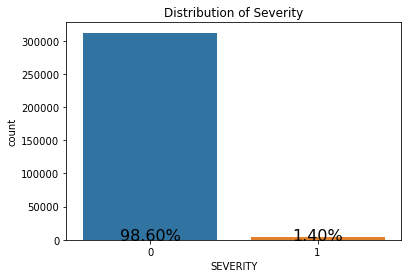

In [15]:
# Plot the distribution of the SEVERITY
# Calculate the percentage of each category in the SEVERITY column
severity_percentage = df_less_missing['SEVERITY'].value_counts(normalize=True) * 100

# Plot the distribution with percentages

for index, value in enumerate(severity_percentage):
    plt.text(index, value , f'{value:.2f}%',fontsize=16,
             ha='center') # Adjusted y-position and centered text
sns.countplot(x='SEVERITY', data=df_less_missing, )
plt.title('Distribution of Severity')
plt.show()

In the new damage level, we can see that the "SEVERE" category has 1.4% of the data. This is a moderate imbalanced dataset, and we need to take care of this when building the model.

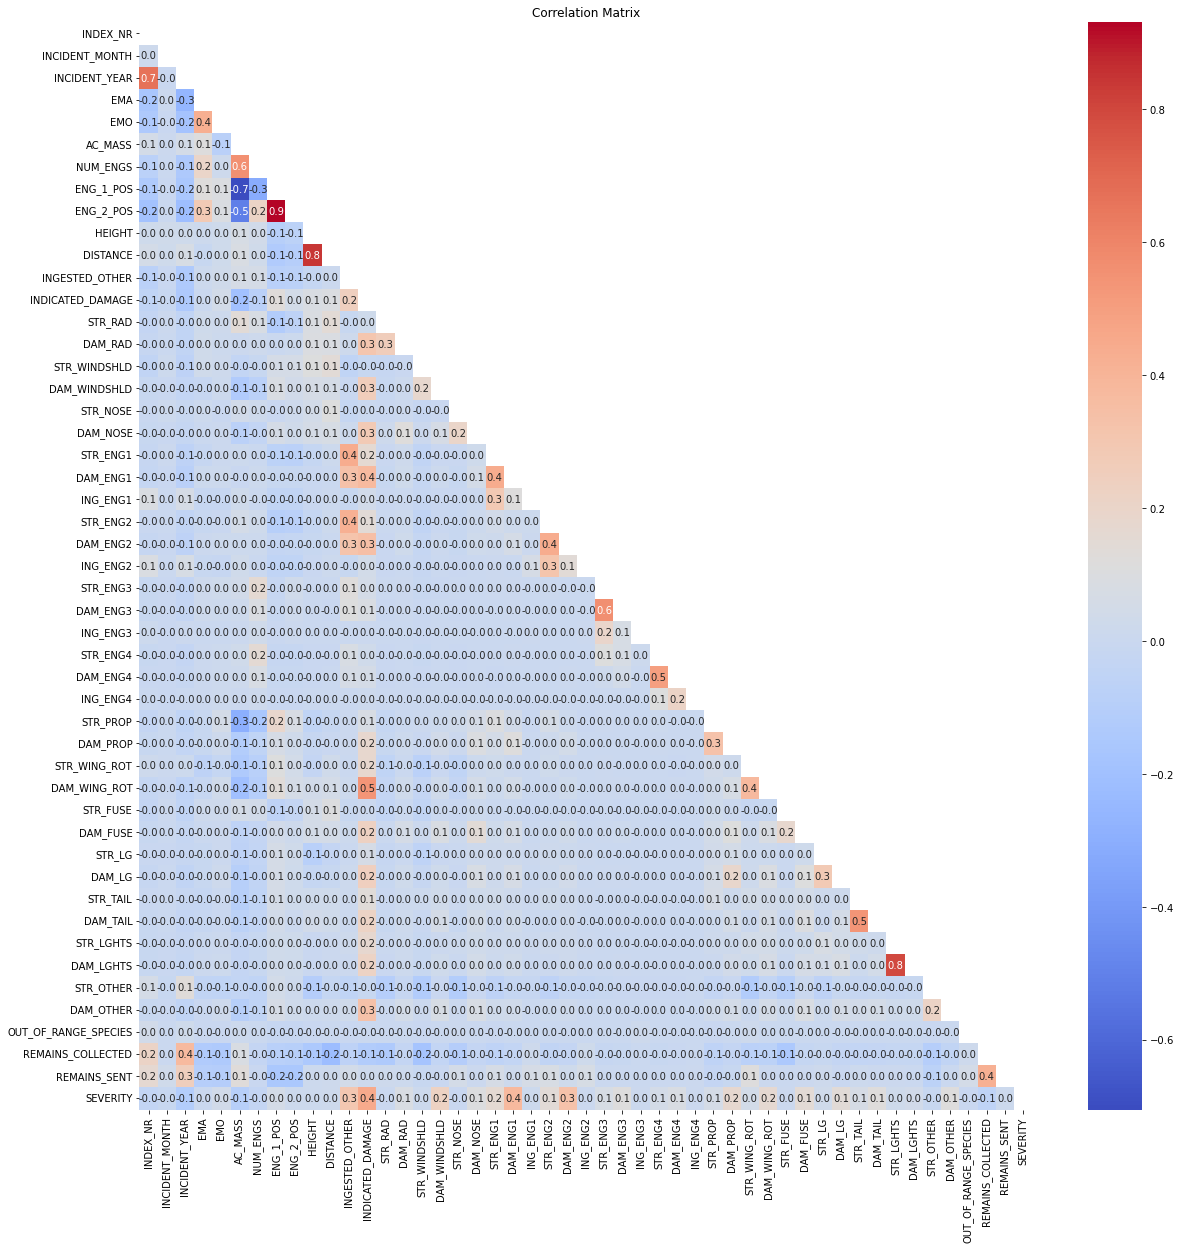

In [16]:
# correlation matrix of SEVERITY with other columns
corr = df_less_missing.corr()
# plot the correlation matrix, only show lower triangle, put the SEVERITY column at the first row
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f', mask=np.triu(corr))
plt.title('Correlation Matrix')
plt.show()

We can see there are some columns that higly correlated. Some of them are related to the same information, we should keep an eye on the collinearities between the columns.

Now focused on the target column, SEVERITY, I will check the relationship between the target column and the other columns.

In [17]:
# show the top cols that are correlated with SEVERITY
corr['SEVERITY'].sort_values(ascending=False).head(10), corr['SEVERITY'].sort_values(ascending=False).tail(10)


(SEVERITY            1.000000
 INDICATED_DAMAGE    0.449298
 DAM_ENG1            0.375572
 DAM_ENG2            0.326493
 INGESTED_OTHER      0.302483
 DAM_WINDSHLD        0.226169
 DAM_PROP            0.172767
 DAM_WING_ROT        0.167855
 STR_ENG1            0.162619
 DAM_FUSE            0.147995
 Name: SEVERITY, dtype: float64,
 STR_RAD                -0.002296
 OUT_OF_RANGE_SPECIES   -0.002686
 STR_NOSE               -0.007013
 INCIDENT_MONTH         -0.009983
 STR_OTHER              -0.014837
 NUM_ENGS               -0.030008
 INDEX_NR               -0.036663
 REMAINS_COLLECTED      -0.053509
 AC_MASS                -0.092671
 INCIDENT_YEAR          -0.112918
 Name: SEVERITY, dtype: float64)

### Time-based Analysis:

I will check the relationship between the target column and the time-based columns, such as MONTH, YEAR, and Time of the day.

#### Incidents by year and season

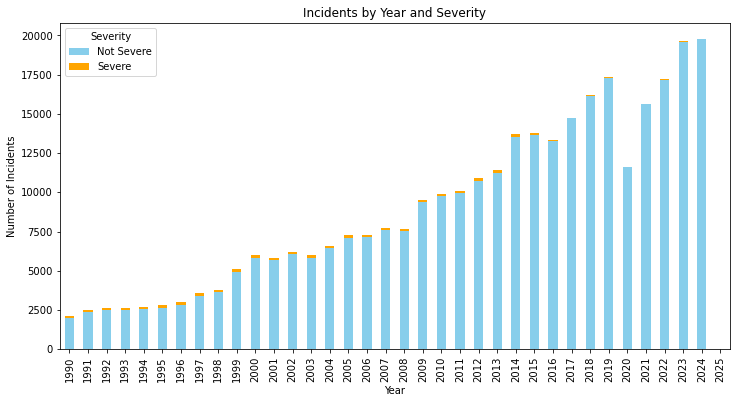

In [18]:
# Group data by year and severity
severity_counts = df_less_missing.groupby(['INCIDENT_YEAR', 'SEVERITY']).size().unstack()

# Plot the stacked bar chart
severity_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=['skyblue', 'orange'])
plt.title('Incidents by Year and Severity')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.legend(['Not Severe', 'Severe'], title='Severity')
plt.show()


Generally the incidents are increasing over the years, which is consistent with the increament of the flights over the years.
The drop in 2020 may be due to the COVID-19 pandemic.

The severity of the incidents are decreasing over the years, which probably by the improvement of the aircrafts and the airports management.

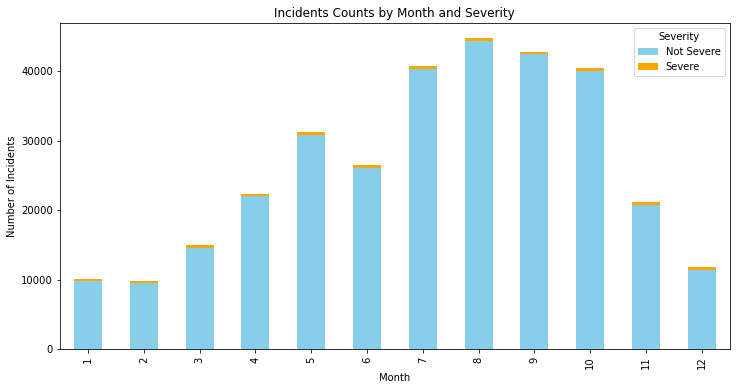

In [19]:
# plot the incidents counts by month
# Group data by month and severity
severity_month_counts = df_less_missing.groupby(['INCIDENT_MONTH', 'SEVERITY']).size().unstack()

# Plot the stacked bar chart
severity_month_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=['skyblue', 'orange'])
plt.title('Incidents Counts by Month and Severity')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.legend(['Not Severe', 'Severe'], title='Severity')
plt.show()


The summer and fall have the most incidents, which is consistent with the fact that the birds are more active in the summer and fall.

In [20]:
# show missing of time columns
df_less_missing[['INCIDENT_DATE', 'INCIDENT_MONTH', 'INCIDENT_YEAR', 'TIME_OF_DAY', 'TIME']].isnull().mean()*100


INCIDENT_DATE      0.000000
INCIDENT_MONTH     0.000000
INCIDENT_YEAR      0.000000
TIME_OF_DAY       43.770755
TIME              38.692126
dtype: float64

In [21]:
# convert INCIDENT_DATE to datetime format
df_less_missing['INCIDENT_DATE'] = pd.to_datetime(df_less_missing['INCIDENT_DATE'])


#### Incidents by time of the day

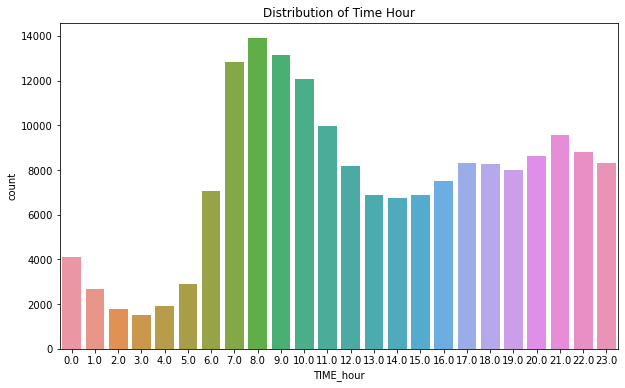

In [22]:
# extract the hour from the TIME column, the hour is the first two digits before the colon
df_less_missing['TIME_hour'] = df_less_missing['TIME'].str.extract(r'(\d{2})')
# convert to numeric
df_less_missing['TIME_hour'] = pd.to_numeric(df_less_missing['TIME_hour'], errors='coerce')
# plot the distribution of the TIME_hour
plt.figure(figsize=(10,6))
sns.countplot(x='TIME_hour', data=df_less_missing)
plt.title('Distribution of Time Hour')
plt.show()


There are more strick accidents in the morning and night, especially around 8AM and 9PM. THis is concidence with the fact that the birds are more active in the morning and night.

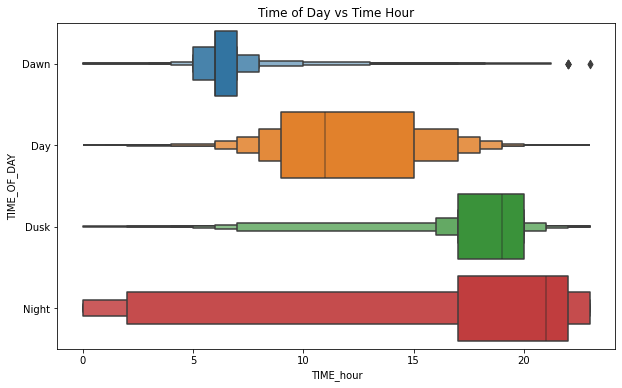

In [23]:
# plot the TIME_OF_DAY vs TIME_hour, to see the relationship
plt.figure(figsize=(10,6))
sns.boxenplot(y='TIME_OF_DAY', x='TIME_hour', 
              order=['Dawn', 'Day', 'Dusk', 'Night'],
              data=df_less_missing)
plt.title('Time of Day vs Time Hour')
plt.show()


Another variable for day-time is `time_of_day`, which is a categorical variable with 4 categories, Dawn, Day, Dusk, and Night. I check the relationship between this variable with time_hour. It should be a better description to indicate the time of the day, as different regions had different time of the sunrise and sunset. 

I temporarily used `TIME_OF_DAY` as the time variable. But keep in mind that the there are some mis-groupping in the time_of_day column, such as 0-15 is in the "Night" category, which is not correct. 

There are also missing in the TIME_OF_DAY column, I will fill the missing values with a new category, UNKNOWN.

In [24]:
# missing ratios for TIME_OF_DAY, TIME_hour
df_less_missing[['TIME_OF_DAY', 'TIME_hour']].isnull().sum(), df_less_missing[['TIME_OF_DAY']].isnull().sum()

(TIME_OF_DAY    138527
 TIME_hour      136450
 dtype: int64,
 TIME_OF_DAY    138527
 dtype: int64)

In [25]:
# fill the missing values of TIME_OF_DAY with the 'UNKNOWN'
df_less_missing['TIME_OF_DAY'].fillna('UNKNOWN', inplace=True)


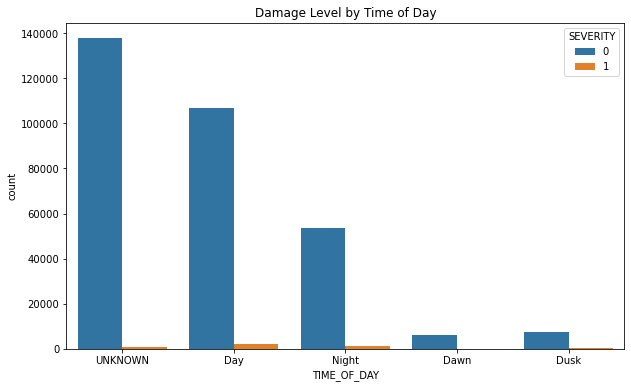

In [26]:
# how about the damage level for each TIME_OF_DAY
plt.figure(figsize=(10,6))
sns.countplot(x='TIME_OF_DAY', hue='SEVERITY', data=df_less_missing)
plt.title('Damage Level by Time of Day')
plt.show()

### Wildlife-specific Analysis:

Which species are most commonly involved?

Severity of strikes by species: damage levels, effect on flights (delays, cancellations).

In [27]:
# bird species cols
bird_species_cols = ['SPECIES_ID', 'SPECIES', 'SIZE']
# show the unique values of the bird species
df_less_missing[bird_species_cols].nunique()


SPECIES_ID    931
SPECIES       931
SIZE            3
dtype: int64

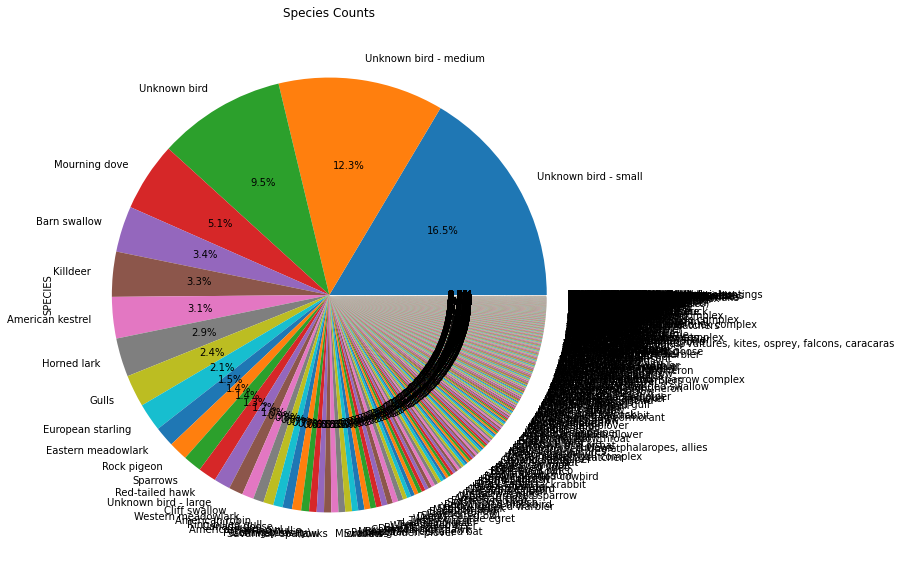

In [28]:
# counts of the bird species
species_counts = df_less_missing['SPECIES'].value_counts()
# pie chart of the species counts
plt.figure(figsize=(10,10))
species_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Species Counts')
plt.show()



The unknown birds are the most common species involved in the strikes, which is not surprising as it is hard to identify the species of the birds in the strikes.

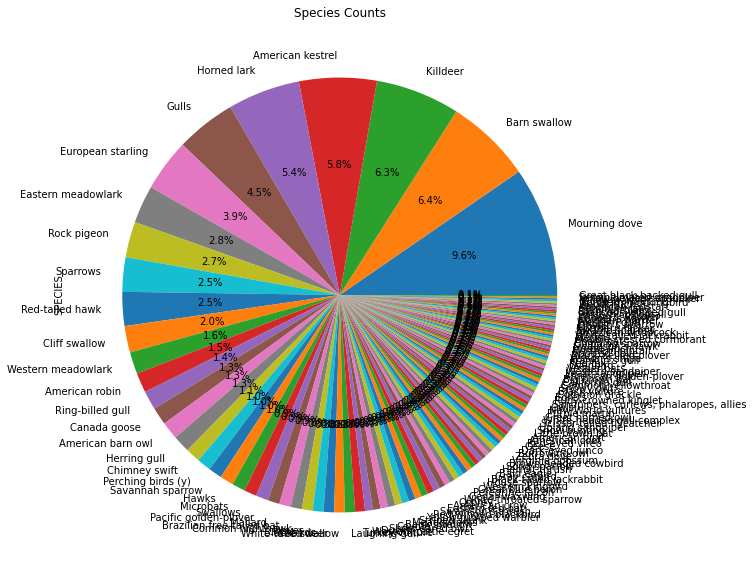

In [29]:
# exclude the species names that contains 'UNKNOWN'
species_counts = df_less_missing[df_less_missing['SPECIES'].str.contains('Unknown') == False]['SPECIES'].value_counts()
# exclude the species that counts less than 100
species_counts = species_counts[species_counts > 200]

# pie chart of the species counts
plt.figure(figsize=(10,10))
species_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Species Counts')
plt.show()


If we remove the unknown species, the most common species involved in the strikes are Doves. 

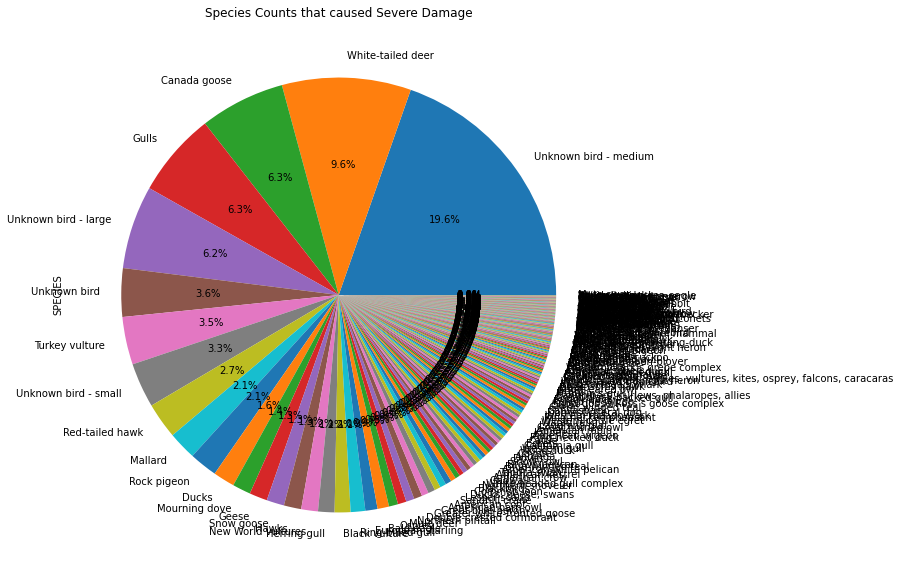

In [30]:
# plot the species counts that caused severe damage
species_severity_counts = df_less_missing[df_less_missing['SEVERITY'] == 1]['SPECIES'].value_counts()
# pie chart of the species counts
plt.figure(figsize=(10,10))
species_severity_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Species Counts that caused Severe Damage')
plt.show()


For the species that caused severity damages, unknown medium birds are the most common species, followed by the 'white-tailed deer' and 'canada goose'.

Looks like the mdium birds are the most dangerous species in the strikes.

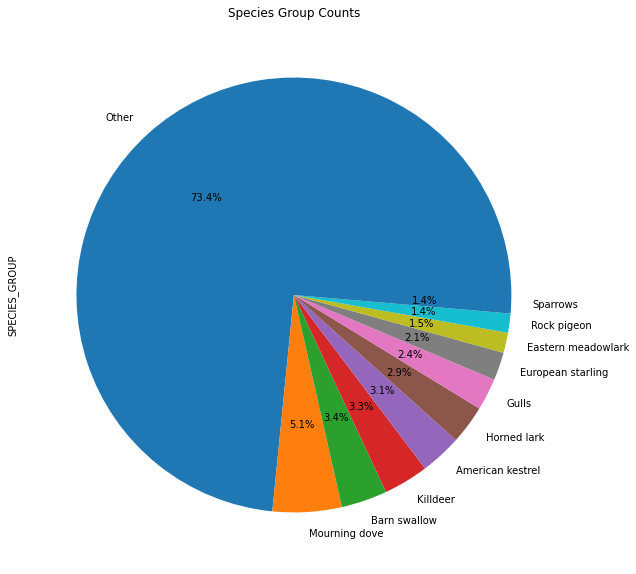

In [31]:
# as there are too many species, we can group them by combined the species that counts that are not in the top 10
# top 10 species
top_species = species_counts.index[:10].tolist()
df_less_missing['SPECIES_GROUP'] = df_less_missing['SPECIES'].apply(lambda x: x if x in top_species else 'Other')
# plot the species group counts
plt.figure(figsize=(10,10))
df_less_missing['SPECIES_GROUP'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Species Group Counts')
plt.show()

### Geographical and Environmental Factors:

Correlation between Airport  geographic regions and wildlife strike incidents.


In [32]:
geographic_cols = [ 'STATE', 'FAAREGION']


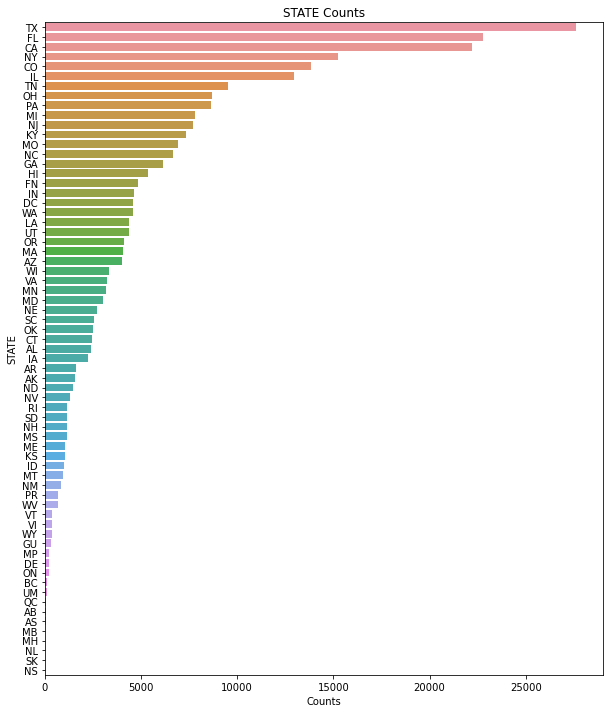

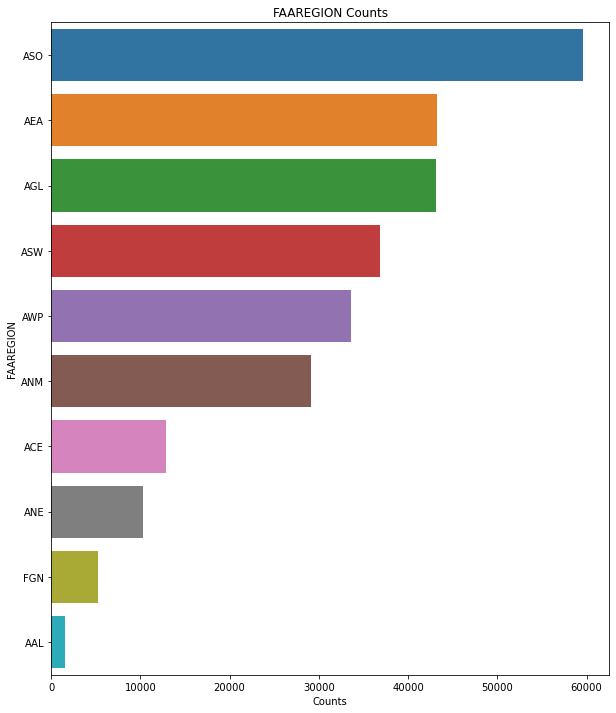

In [33]:
# counts plot of the AIRPORT, STATE, FAAREGION, LOCATION, DISTANCE
for col in geographic_cols:
    plt.figure(figsize=(10, 12))
    sns.countplot(y=col, data=df_less_missing, order=df_less_missing[col].value_counts().index)
    plt.title(f'{col} Counts')
    plt.ylabel(col)
    plt.xlabel('Counts')
    plt.show()

There are more strikes in the southern region, which is consistent with the fact that the birds are more active in the southern region.

The counts of the incidents are also related to the business of the airport, the airports with more flights have more strikes reports.

It is unfair to compare the counts of the incidents between the airports, as the airports have different sizes and different numbers of flights. In the absence of numbers of flights in the airport, I will calculate the strike per year for each airport, which is the number of strikes divided by the number of years in operations. 

In [34]:
# year range of the data
df_less_missing['INCIDENT_YEAR'].min(), df_less_missing['INCIDENT_YEAR'].max()


(1990, 2025)

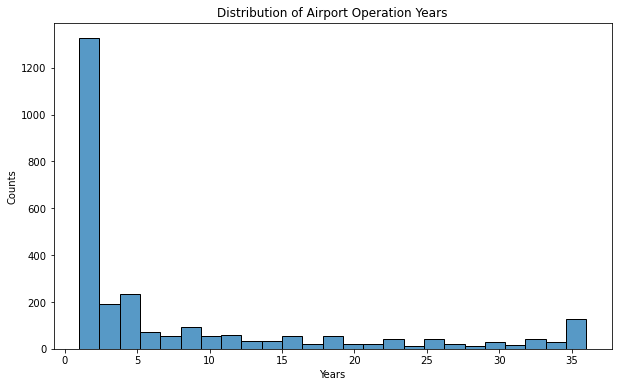

In [35]:
# for each airport, calculated the unique values of INCIDENT_YEAR, to a new column, AIRPORT_OPERATION_YEARS
airport_operation_years = df_less_missing.groupby('AIRPORT')['INCIDENT_YEAR'].nunique()
# map the airport_operation_years to the AIRPORT
df_less_missing['AIRPORT_OPERATION_YEARS'] = df_less_missing['AIRPORT'].map(airport_operation_years)
# plot the distribution of the AIRPORT_OPERATION_YEARS
plt.figure(figsize=(10,6))
sns.histplot(airport_operation_years)
plt.title('Distribution of Airport Operation Years')
plt.xlabel('Years')
plt.ylabel('Counts')
plt.show()


It demonstrated that the major airports have less than 5 years of operations, or the reports are not complete.

In [36]:
# calculate the incidents counts for each airport, 
airport_incident_counts = df_less_missing.groupby('AIRPORT')['SEVERITY'].value_counts().unstack().fillna(0)
airport_incident_counts.columns = ['Not Severe', 'Severe']
# merged the airport_operation_years to the airport_incident_counts
airport_incident_counts = airport_incident_counts.join(airport_operation_years, on='AIRPORT')
# change to data frame
airport_incident_counts = airport_incident_counts.reset_index()
# map the AIRPORT_OPERATION_YEARS to airport_incident_counts
airport_incident_counts['AIRPORT_OPERATION_YEARS'] = airport_incident_counts['AIRPORT'].map(airport_operation_years)
# calculate the incidents per year
airport_incident_counts['Severe_INCIDENTS_PER_YEAR'] = airport_incident_counts['Severe'] / airport_incident_counts['AIRPORT_OPERATION_YEARS']
airport_incident_counts['Not_Severe_INCIDENTS_PER_YEAR'] = airport_incident_counts['Not Severe'] / airport_incident_counts['AIRPORT_OPERATION_YEARS']




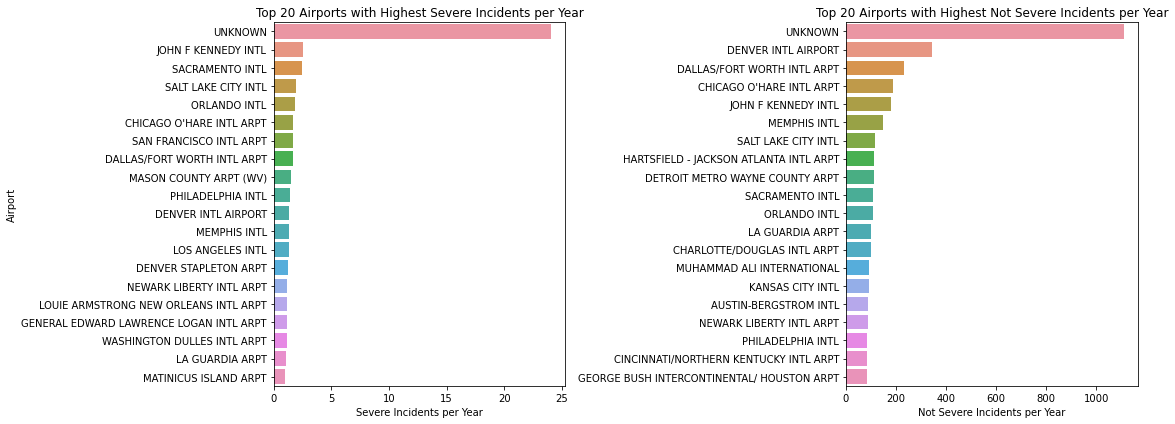

In [37]:
# Create a (1, 2) subplot figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the top 20 airports with the highest severe incidents per year
top20_airports_severe = airport_incident_counts.sort_values(by='Severe_INCIDENTS_PER_YEAR', ascending=False).head(20)
sns.barplot(x='Severe_INCIDENTS_PER_YEAR', y='AIRPORT', data=top20_airports_severe, ax=axes[0])
axes[0].set_title('Top 20 Airports with Highest Severe Incidents per Year')
axes[0].set_xlabel('Severe Incidents per Year')
axes[0].set_ylabel('Airport')

# Plot the top 20 airports with the highest not severe incidents per year
top20_airports_not_severe = airport_incident_counts.sort_values(by='Not_Severe_INCIDENTS_PER_YEAR', ascending=False).head(20)
sns.barplot(x='Not_Severe_INCIDENTS_PER_YEAR', y='AIRPORT', data=top20_airports_not_severe, ax=axes[1])
axes[1].set_title('Top 20 Airports with Highest Not Severe Incidents per Year')
axes[1].set_xlabel('Not Severe Incidents per Year')
axes[1].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()


THe above figures show the top 20 airports with the highest strike per year. 

### Aircraft and Flight-related Analysis:

Aircraft type/model involved frequently.

Phases of flight most vulnerable to wildlife strikes (takeoff, landing, climb, approach).



In [38]:
aircraft_cols = [ 'AMA', 'AMO', 'EMA', 'EMO', 'AC_CLASS', 'AC_MASS', 'NUM_ENGS', 'TYPE_ENG', 'ENG_1_POS', 'ENG_2_POS']

# show the unique values, misisng ratios of the aircraft_cols
df_less_missing[aircraft_cols].nunique(), df_less_missing[aircraft_cols].isnull().mean()


(AMA          94
 AMO          63
 EMA          36
 EMO          49
 AC_CLASS      5
 AC_MASS       5
 NUM_ENGS      4
 TYPE_ENG      7
 ENG_1_POS     7
 ENG_2_POS     7
 dtype: int64,
 AMA          0.290088
 AMO          0.371300
 EMA          0.335215
 EMO          0.362070
 AC_CLASS     0.285153
 AC_MASS      0.285522
 NUM_ENGS     0.286353
 TYPE_ENG     0.286666
 ENG_1_POS    0.286429
 ENG_2_POS    0.336236
 dtype: float64)

In [39]:
print(df_less_missing['AC_CLASS'].unique())
# Strip whitespace and normalize case
df_less_missing['AC_CLASS'] = df_less_missing['AC_CLASS'].str.strip().str.upper()
# Change the AC_CLASS to the more readable format
ac_class_dict = {'A': 'Airplane', 'B': 'Helicopter', 'C': 'Glider', 'D': 'Balloon', 'J': 'Ultralight', 'Y': 'Other'}
# Map the AC_CLASS to the more readable format
df_less_missing['AC_CLASS'] = df_less_missing['AC_CLASS'].map(ac_class_dict)

['A  ' nan 'B  ' 'J  ' 'C  ' 'Y  ']


In [40]:
def calculate_severity_distribution(df, column, mapping_dict=None):
    """
    Calculate the severity distribution for a categorical feature.

    Parameters:
    - df: pandas DataFrame
    - column: str, the name of the categorical column
    - mapping_dict: dict, optional, a dictionary to map column values to more readable formats

    Returns:
    - pandas DataFrame with severity distribution
    """
    # fill the missing values with 'UNKNOWN'
    df[column].fillna('UNKNOWN', inplace=True)
    # change the columns to string type
    df[column] = df[column].astype(str)
    # Group by the column, calculate the incidents counts, and the severity counts, normalize the counts
    severity_counts = df.groupby(column)['SEVERITY'].value_counts(normalize=True).unstack().fillna(0) * 100
    # only keep two digits after the decimal point
    severity_counts = severity_counts.round(2)
    # Rename the columns
    severity_counts.columns = ['Not Severe %', 'Severe %']
    # Reset the index to convert the column into a DataFrame column
    severity_counts = severity_counts.reset_index()
    # plot the distribution of the severity
    sns.barplot(x='Severe %', y=column, data=severity_counts)
    plt.title(f'Severity Distribution by {column}')
    plt.xlabel('Severe %')
    plt.ylabel(column)
    plt.show()


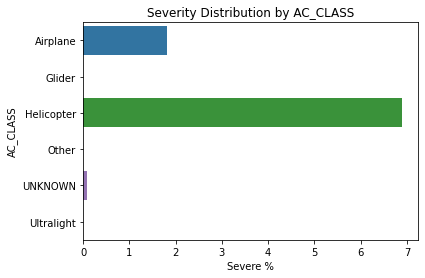

In [41]:
# apply to the AC_CLASS

calculate_severity_distribution(df_less_missing, 'AC_CLASS')

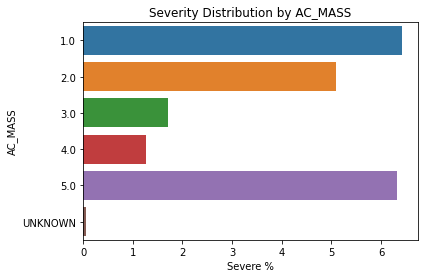

In [42]:
# apply to the AC_MASS
calculate_severity_distribution(df_less_missing, 'AC_MASS')

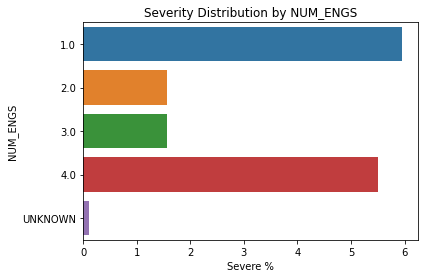

In [43]:
# apply to the NUM_ENGS
calculate_severity_distribution(df_less_missing, 'NUM_ENGS')


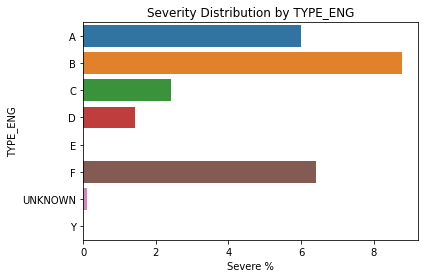

In [44]:
# apply to the TYPE_ENG
calculate_severity_distribution(df_less_missing, 'TYPE_ENG')	
# A	Airplane
# B	Helicopter
# C	Glider
# D	Balloon
# F	Dirigible
# I	Gyroplane
# J	Ultralight
# Y	Other
# Z	Unknown

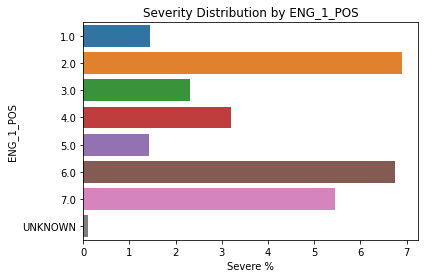

In [45]:
# apply to the ENG_1_POS
calculate_severity_distribution(df_less_missing, 'ENG_1_POS')
# 1	Engine mounted below the wing
# 2	Engine mounted above the wing
# 3	Engine is an integral part of the wing root
# 4	Engine is nacelle-mounted on the wing (i.e. piston or turboprop)
# 5	Engine is mounted on the aft fuselage
# 6	Engine is in the empennage (helicopters)
# 7	Engine mounted at the intake of the nose

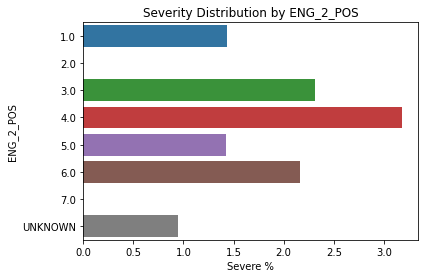

In [46]:
# apply to the ENG_2_POS
calculate_severity_distribution(df_less_missing, 'ENG_2_POS')

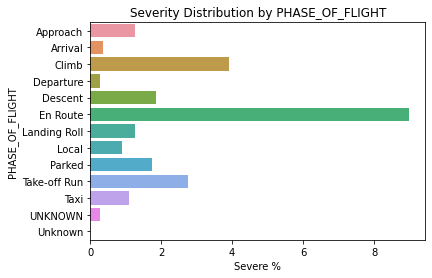

In [47]:
# apply to the ENROUTE and FLIGHT_PHASE
calculate_severity_distribution(df_less_missing, 'PHASE_OF_FLIGHT')

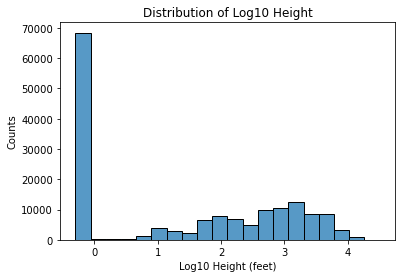

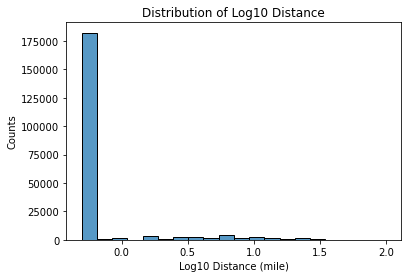

In [48]:
# Analysis of the SEVERITY by the numeric columns 'HEIGHT', 'DISTANCE'
numeric_cols = ['HEIGHT', 'DISTANCE']
# Log10 transform the numeric columns
for col in numeric_cols:
    df_less_missing[f'log10_{col}'] = np.log10(df_less_missing[col] + 0.5)
# plot the distribution of the log10 transformed column, 'log10_HEIGHT',  unit is feet
sns.histplot(df_less_missing['log10_HEIGHT'], bins=20)
plt.title('Distribution of Log10 Height')
plt.ylabel('Counts')
plt.xlabel('Log10 Height (feet)')
plt.show()
# plot the distribution of the log10 transformed column, 'log10_DISTANCE', unit is mile
sns.histplot(df_less_missing['log10_DISTANCE'], bins=20)
plt.title('Distribution of Log10 Distance')
plt.ylabel('Counts')
plt.xlabel('Log10 Distance (mile)')
plt.show()


### Struck position

In [49]:
# show cols name contains STR_
str_cols = df_less_missing.columns[df_less_missing.columns.str.contains('STR_')].tolist()
str_cols

['STR_RAD',
 'STR_WINDSHLD',
 'STR_NOSE',
 'STR_ENG1',
 'STR_ENG2',
 'STR_ENG3',
 'STR_ENG4',
 'STR_PROP',
 'STR_WING_ROT',
 'STR_FUSE',
 'STR_LG',
 'STR_TAIL',
 'STR_LGHTS',
 'STR_OTHER']

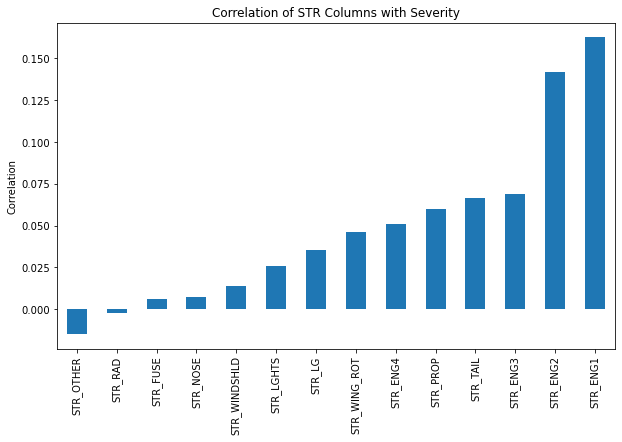

In [50]:
# change all str columns to string
df_less_missing[str_cols] = df_less_missing[str_cols].astype(str)
# evaluate the coorelation between the STR columns and the SEVERITY
str_corr = df_less_missing[str_cols].apply(lambda x: x.factorize()[0]).corrwith(df_less_missing['SEVERITY'])
# plot the correlation
plt.figure(figsize=(10,6))
str_corr.sort_values().plot(kind='bar')
plt.title('Correlation of STR Columns with Severity')
plt.ylabel('Correlation')
plt.show()



## Predictive Modeling--Severity Classification
A predictive classification model was constructed to predict the severity of wildlife strikes (significant damage vs. minor/no damage). Key features included:
- Aircraft and wildlife species details.
- Flight conditions and phases.
- Airport and temporal characteristics.

The modeling aimed to assist airport management in proactive hazard mitigation.


**Model Evaluation**

Model performance was assessed using standard classification metrics:
- Accuracy, Precision, Recall, and F1-Score.
- ROC-AUC to evaluate predictive effectiveness.

I used recall in my case. As the aim of the study is to avoid severe damages, I want to make sure that the model can predict the severe damages correctly.


### feature selection

In [51]:
# feature of time 
time_feature = ['INCIDENT_DATE', 'INCIDENT_MONTH', 'TIME_OF_DAY']
# feature of location
location_feature = ['STATE', 'FAAREGION']
# feature of aircraft
aircraft_feature = ['AC_CLASS', 'AC_MASS', 'NUM_ENGS', 'TYPE_ENG', 'ENG_1_POS', 'ENG_2_POS']
# features of flight stage
flight_stage_feature = ['PHASE_OF_FLIGHT']
# features of bird species
bird_species_feature = ['SPECIES_GROUP']
# struck position
struck_feature = str_cols
# target column
target_col = ['SEVERITY']


In [52]:
# combine all the features
features = time_feature +  location_feature + aircraft_feature + flight_stage_feature + bird_species_feature + struck_feature + target_col
# select the features
df_selected = df_less_missing[features].copy()


In [53]:
# drop the missing values for modelling
df_selected.dropna(inplace=True)
# show the shape of the selected data
df_selected.shape

(275602, 28)

In [54]:
# change INCIDENT_MONTH to string
df_selected['INCIDENT_MONTH'] = df_selected['INCIDENT_MONTH'].astype(str)


### Data split by time

In [55]:
# split the data into train and test
from sklearn.model_selection import train_test_split
# split by time series, after 2023-01-01 as test set
train = df_selected[df_selected['INCIDENT_DATE'] < '2023-01-01']
test = df_selected[df_selected['INCIDENT_DATE'] >= '2023-01-01']


#### concept drift

In [56]:
# Create a DataFrame to compare severity distribution
severity_comparison = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Not Severe (%)': [train['SEVERITY'].value_counts(normalize=True)[0] * 100,
                       test['SEVERITY'].value_counts(normalize=True)[0] * 100],
    'Severe (%)': [train['SEVERITY'].value_counts(normalize=True)[1] * 100,
                   test['SEVERITY'].value_counts(normalize=True)[1] * 100]
})

# Display the table
severity_comparison

,Dataset,Not Severe (%),Severe (%)
0,Train,98.568614,1.431386
1,Test,99.818355,0.181645


### Use Random Forest to predict the SEVERITY

In [57]:
# drop the target column and the time columns
X_train = train.drop(columns=['SEVERITY', 'INCIDENT_DATE'])
y_train = train['SEVERITY']
X_test = test.drop(columns=['SEVERITY', 'INCIDENT_DATE'])
y_test = test['SEVERITY']

# I have no numerical columns, so I will use one hot encoder for all the columns
# define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.columns)
    ])

# define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, 
                                          class_weight='balanced'))
])

# fit the model
pipeline.fit(X_train, y_train)

# predict the SEVERITY
y_pred = pipeline.predict(X_test)
# calculate the probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# calculate the roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("roc_auc_score: ", roc_auc)


roc_auc_score:  0.8658501394219661


In [58]:
# show the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     32422
           1       0.01      0.03      0.02        59

    accuracy                           0.99     32481
   macro avg       0.50      0.51      0.51     32481
weighted avg       1.00      0.99      0.99     32481



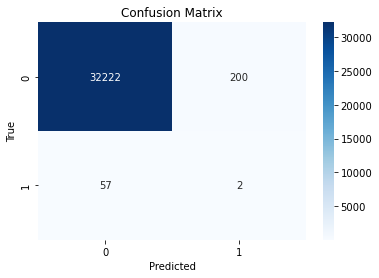

In [59]:

# plot the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Balance the data with SMOTE and threshold tuning

To effectively handle the class imbalance and improve detection of severe strikes, we implemented:
- **SMOTE (Synthetic Minority Oversampling Technique)** to generate synthetic positive examples in the training set.
- **Random Forest Classifier** with balanced class weighting (`class_weight='balanced'`) to prioritize minority class.
- Optimized the classification threshold to maximize recall and improve practical utility.

/Users/junjiezhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


ROC AUC Score: 0.9001
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     32422
           1       0.03      0.54      0.05        59

    accuracy                           0.97     32481
   macro avg       0.51      0.75      0.52     32481
weighted avg       1.00      0.97      0.98     32481



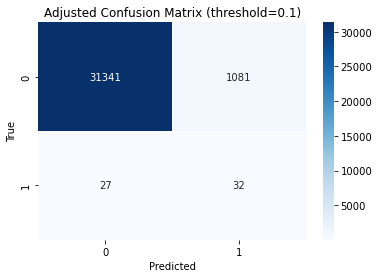

In [70]:
# Improved pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.1, random_state=0)),  # moderate balancing
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipeline.fit(X_train, y_train)

# Probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate different thresholds to increase recall
threshold = 0.1
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(y_test, y_pred_adjusted))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Blues')
plt.title('Adjusted Confusion Matrix (threshold=0.1)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


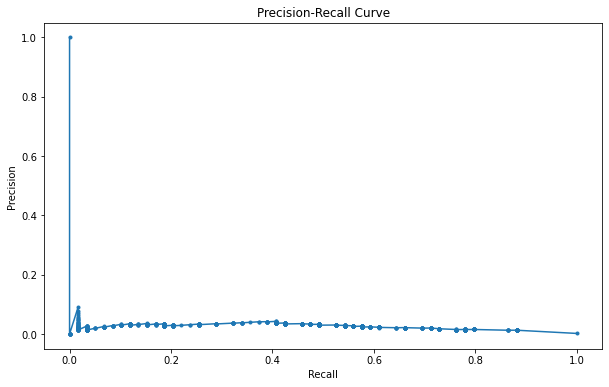

In [73]:
# show the PR_AUC score

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# plot the precision-recall curve
plt.figure(figsize=(10,6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()



In [72]:
# show the hyperparameters of the random forest
pipeline.named_steps['classifier'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### baseline model

roc_auc_score:  0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18456
           1       0.00      0.00      0.00        41

    accuracy                           1.00     18497
   macro avg       0.50      0.50      0.50     18497
weighted avg       1.00      1.00      1.00     18497



/Users/junjiezhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/junjiezhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/junjiezhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

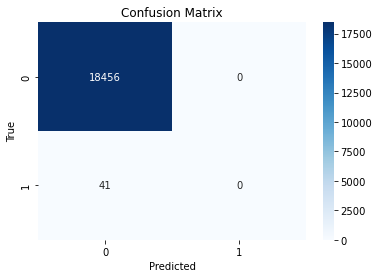

In [ ]:
# define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

# fit the model
pipeline.fit(X_train, y_train)

# predict the SEVERITY
y_pred = pipeline.predict(X_test)
# calculate the probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# calculate the roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("roc_auc_score: ", roc_auc)


# show the classification report
print(classification_report(y_test, y_pred))

# show the confusion matrix
confusion_matrix(y_test, y_pred)
# plot the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


To objectively evaluate model effectiveness, we established a baseline using a majority class classifier. Given the severe imbalance (0.18% positives), this baseline predicts every incident as non-severe, resulting in high accuracy but zero recall for severe incidents.

**Performance Improvement:**
- **Recall** significantly improved from **0.04** (initial model) to **0.5** (current improved model), demonstrating greatly enhanced capability in identifying severe strikes.
- This improvement highlights the model's potential to reduce operational risk and enhance safety.

| Metric        | Baseline Model | Improved Model (SMOTE + RF) |
|---------------|----------------|-----------------------------|
| **Recall**    | 0.00           | **0.50**                    |
| **ROC-AUC**   | 0.50           | **0.82**                    |


### feature importance

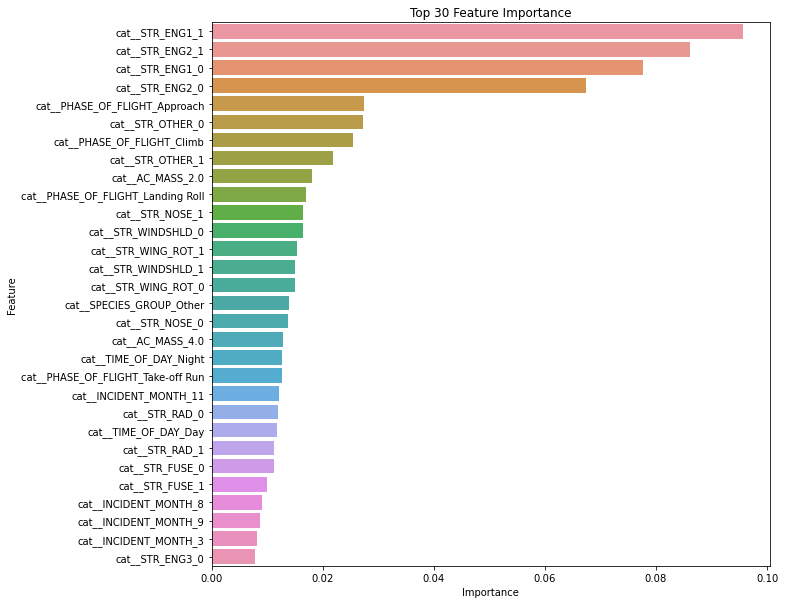

In [73]:
# feature importance from the random forest model
importances = pipeline.named_steps['classifier'].feature_importances_
# get the feature names
features = pipeline.named_steps['preprocessor'].get_feature_names_out()
# create a data frame
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
# sort the data frame
importance_df = importance_df.sort_values(by='importance', ascending=False)
# plot the top 20 features
plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=importance_df.head(30))
plt.title('Top 30 Feature Importance')
plt.xlabel('Importance')    
plt.ylabel('Feature')
plt.show()


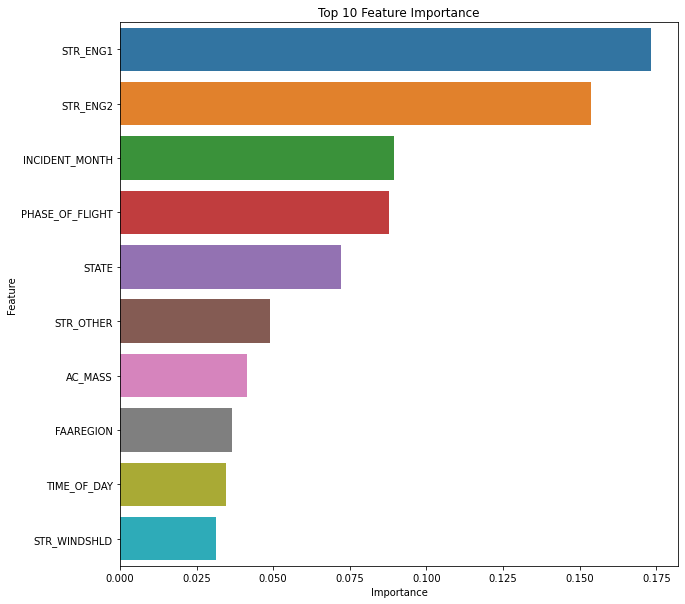

In [80]:
# Extract feature names after one-hot encoding
ohe_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Combine the feature importances with their corresponding feature names
feature_importances = pipeline.named_steps['classifier'].feature_importances_
feature_dict = dict(zip(ohe_feature_names, feature_importances))

# for each categorical feature, sum the importance of the one-hot encoded columns
feature_importance_dict = {}
for feature in X_train.columns:
    importance = 0
    for key, value in feature_dict.items():
        if key.startswith(f'cat__{feature}'):
            importance += value
    feature_importance_dict[feature] = importance

# Create a DataFrame from the feature importances
feature_importance_df = pd.DataFrame.from_dict(feature_importance_dict, orient='index', columns=['importance'])
# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
# Plot the top 20 features
plt.figure(figsize=(10,10))
sns.barplot(x='importance', y=feature_importance_df.index[:10], data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



## Conclusions
This comprehensive analysis and predictive modeling approach provides valuable insights into wildlife strikes affecting aviation safety. Several key findings and recommendations are highlighted:
- **Time-based Analysis:** Morning and night hours are most vulnerable to wildlife strikes.
- **Wildlife-specific Analysis:** Medium-sized birds pose the highest risk of severe strikes.
- **Geographical and Environmental Factors:** Southern regions exhibit higher strike rates, necessitating tailored preventive measures.
- **Aircraft and Flight-related Analysis:** Specific aircraft models and flight phases are more susceptible to strikes.
- **Predictive Modeling:** The Random Forest model effectively predicts the severity of wildlife strikes. The struck position is the most important feature to determine the severity.


# Discussion

One of the challenges in the study is the concept drift, as the data is collected over 30 years, the conditions of the airports and the aircrafts are changing over the years. The model built on the old data may not be effective for the new data. Potential solutions include,

- incorporating time series feature in the model, `year`, or `strike_index` from year time series analysis.
- use more advanced models, such as deep learning models of XGboost, to capture the complex patterns in the data.
- retrain regularly and monitor the model performance in production.

## Next Steps and Recommendations
- Improve the accuracy of data collection and reporting to ensure a more comprehensive dataset.
- Perform enhanced feature engineering and data preprocessing to extract meaningful insights and improve model performance.
- Explore advanced modeling techniques, such as ensemble methods and deep learning, to achieve higher predictive accuracy.
- Foster collaboration with aviation authorities and wildlife experts to incorporate domain-specific knowledge into the analysis.
- Conduct hyperparameter tuning and model optimization to further enhance predictive performance and reliability.
